<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 2</div>
<div style="text-align: right">Reproduction of Bayesian Log Regression by J. Benjamin Cook
<div style="text-align: right"> Author: Peadar Coyle and J. Benjamin Cook, very slightlhy modified by Dino</div>
https://docs.pymc.io/notebooks/GLM-logistic.html</div>


# Bayesian linear-logistic estimation lab

Modeling one of the parameters of a model likelihood with a linear combination of independent variables is one exemplar of Bayesian estimation that works well when the depdent variable is continuous. When it is binary, that variable is often modelled with a logistic likelihood, so I wanted to show you how that is done. This notebook is a reproduction of work by Peadar Coyle and Benjamin Cook that is outstanding. I only modified it slightly.

The [Adult Data Set](http://archive.ics.uci.edu/ml/datasets/Adult) is commonly used to benchmark machine learning algorithms. By the way, the UCI repository is my favorite data repository for data science experiments.

The goal is to use demographic features, or variables, to predict whether an individual makes more than \$50,000 per year. The data set is almost 20 years old, and therefore, not perfect for determining the probability that you will make more than $50K, but it is a nice, simple dataset that can be used to showcase a few benefits of using Bayesian logistic regression.

- ***Important*** note: The bayesian computations in this notebook will easily take your laptop an hour to complete, so ***please*** do not start them in class. Start them at home. For now, just follow the already evaluated results.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as T

d:\Anaconda3.5.1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The functions below are utility functions.

In [2]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

We read the dataset straight from the Web, from the UCI machine learning data repository:

In [3]:
raw_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                       header=None,
                       names=['age', 'workclass', 'fnlwgt',
                              'education-categorical', 'educ',
                              'marital-status', 'occupation',
                              'relationship', 'race', 'sex',
                              'captial-gain', 'capital-loss',
                              'hours', 'native-country',
                              'income'])

In [4]:
raw_data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


We need to remove any null entries in Income. And we also want to restrict this study to the United States

In [8]:
data = raw_data[~pd.isnull(raw_data['income'])]
data[data['native-country']==" United-States"].sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
6531,31,Private,128220,7th-8th,4,Widowed,Adm-clerical,Not-in-family,White,Female,0,0,35,United-States,<=50K
11347,20,Private,105585,Some-college,10,Never-married,Sales,Own-child,White,Male,0,0,25,United-States,<=50K
17504,39,Private,28572,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,48,United-States,<=50K
5431,51,Private,143741,Some-college,10,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,United-States,>50K
21526,37,Private,236328,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,48,United-States,<=50K


We make `'income` a binary variable, predicated on more or less than 50K.

In [9]:
income = 1 * (data['income'] == " >50K")

We restrict independent variables to just `age`, `education`, and `hours`, and scale age by 10 for better convergence purposes.

We also add a new variable that is the ***square of the age variable***. Ohhhhhhh...

In [10]:
data = data[['age', 'educ', 'hours']]

# Scale age by 10, it helps with model convergence.
data['age'] = data['age']/10.
data['agesquared'] = np.square(data['age'])
data['income'] = income

In [11]:
income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

Let us get a feel for the parameters. We see that age is a tailed distribution. Certainly not Gaussian! 

We don’t see much of a correlation between many of the features, with the exception of Age and Age2. 

Hours worked has some interesting behaviour. 

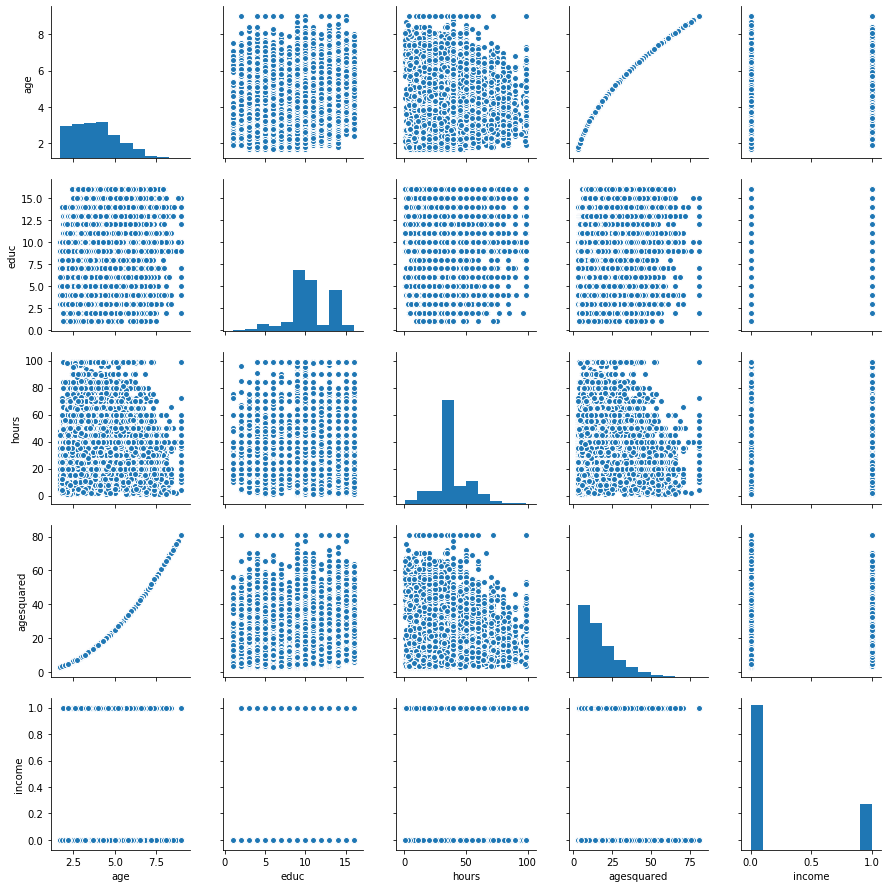

In [12]:
g = seaborn.pairplot(data)

Let's compute the correlation matrix:

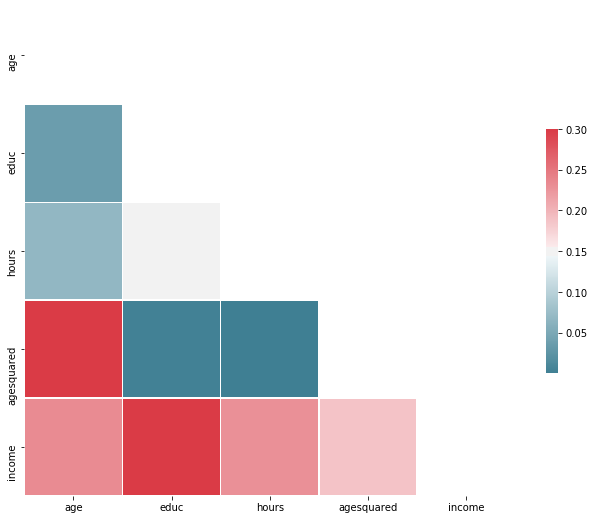

In [13]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

So, ***not many strong correlations***. 

The highest is 0.30 according to this plot. We see a weak-correlation between hours and income (which is logical), we see a slighty stronger correlation between education and income

## The model

Rather than model the binary outcome explicitly, it makes sense instead to model the *probability* of making more than $50K in a **stochastic** model. Probabilities are measured on a continuous [0,1] scale, which may be more amenable for prediction using a regression line. 

If we consider the **Bernoulli** distribution as a generative model:

<div style="font-size: 120%;">  
$$f(p\;|\;y) = p^{y} (1-p)^{1-y}$$ 
</div>  

where $y = \{0,1\}$ and $p \in [0,1]$. Notice that when $y=1$, the $1-p$ term disappears, and when $y=0$, the $p$ term disappears.

So, if we want to fit a **linear model** to the probability, it should look something like this:

<div style="font-size: 120%;">  
$$p_i = \beta_0 + \beta_1 x_i + \epsilon_i$$
</div>

However, since $p$ is constrained to be between zero and one, it is easy to see where a linear (or polynomial) model might predict values outside of this range. We can modify this model sligtly by using a **link function** to transform the probability. Specifically, we can use a **logistic transformation** as our link function:

<div style="font-size: 120%;">  
$$\text{logistic}(p) = \log\left[\frac{p}{1-p}\right] = x$$
</div>

Here's a plot of $p/(1-p)$

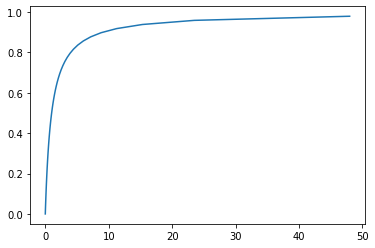

In [24]:
logit = lambda p: np.log(p/(1.-p))
unit_interval = np.linspace(0,1)
plt.plot(unit_interval/(1-unit_interval), unit_interval)

And here's the logistic function:

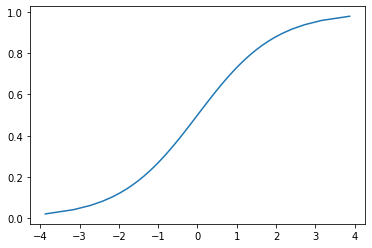

In [25]:
plt.plot(logit(unit_interval), unit_interval)

The inverse of the logit transformation is:

<div style="font-size: 150%;">  
$$\text{invlogit}(x) = \frac{1}{1 + e^{-x}}$$
</div>

So we have a way to use an analytic function to constrain a linear model to a probability bound that we will use to model whether a binary variable is more probably close to zero, or more probably close to 1.

Our model will take on the probability of making more than $50K as a function of **age**, **years of education** and **hours worked per week**. We will use PyMC3 do inference.

In Bayesian statistics, we treat everything as a **random variable** and we want to know the **posterior probability distribution** of the parameters of our model (in this case the regression coefficients).

$$p(\theta \;|\; D) = \frac{p(D\;|\;\theta)\;p(\theta)}{p(D)}$$

Because the denominator is a notoriously difficult integral, $p(D) = \int p(D \;|\; \theta) p(\theta) d\theta$, we would prefer to skip computing it. Fortunately, as we saw with our Metropolis algorithm, if we draw successive amples from parameter space with probability proportional to the ratio of the successive numerators in Bayes' formula, we end up with an empirical distribution that ***converges to the posterior*** as the number of samples approaches infinity.

What this means in practice is that we only need to worry about the numerator. Yipeeeeeee!

Now, we need to specify a **prior** and a **likelihood** in order to draw samples from the posterior. 

We could use sociological knowledge about the effects of age and education on income, but instead, let’s use the default prior specification for GLM coefficients that PyMC3 gives us, which is:

$$p(θ) = N(0, 100)$$

This is a ***very vague*** prior, almost like a Uniform prior, that says "*no se, senor!*" (spanish).

Since we want to predict a binary variable, we know from statistical model knowledge that the likelihood is the product of $n$ Bernoulli trials:

$$\prod^{n}_{i=1} p_{i}^{y} (1 - p_{i})^{1-y_{i}}$$

where $y_i=1$ if income is greater than 50K and $y_i=0$ otherwise, and we model the Bernoulli probability as the inverse logistic:

$$p_i = \frac{1}{1 + e^{-z_i}}$$

Note that the logistic function is the following:  

<div style="font-size: 120%;">  
$$\text{logistic}(p) = \log\left[\frac{p}{1-p}\right]$$
</div>

And we model the stochastic variable $z$ as 

$$z_{i} = \beta_{0} + \beta_{1}(age)_{i} + \beta_2(age)^{2}_{i} + \beta_{3}(educ)_{i} + \beta_{4}(hours)_{i}$$

***Woooooo! Where did all that math come from?*** Simple, trial and error and many ***sleepless nights*** for students and researchers has proven that this is the ***better way*** to model a binary dependent variable with a linear combination of independent variables, when we think that all the independent variables play about the same important role in determining the dependent variable.

But ***wait***, what is that `age`$^2$ parameter, and why do we need it when it's obviously (albeit non-linearly) correlated with `age`!? 

Well, the good folks that did this research found out that income>50k is not so linear with age, but **quadratic** instead. How? ***I do not know***. But obviously they found that thus quadratic model is better. So we'll go along, but I suggest you don't try this with *your* dataset. That's pretty advanced *juju*! 

## Bayesian estimation

Let's use PyMC3 to draw samples from the posterior. The sampling algorithm used is NUTS, in which parameteres are tuned automatically. 

Here we borrow the syntax of specifying GLM’s (Generalized Linear Models) from R, which I mentionned in class. In python, it's called [**patsy**](https://patsy.readthedocs.io/en/latest/formulas.html) style. It's this expression, which says that we want income to be a linear combination of the other variables: `income ~ age + age2 + educ + hours`.

We use a convenience function from above to plot the trace information from the first 1000 parameters.

In [14]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('income ~ age + agesquared + educ + hours',
                            data,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hours, educ, agesquared, age, Intercept]
Sampling 4 chains: 100%|██████████| 8000/8000 [7:42:45<00:00,  1.90draws/s]       
The acceptance probability does not match the target. It is 0.8810525130100262, but should be close to 0.8. Try to increase the number of tuning steps.


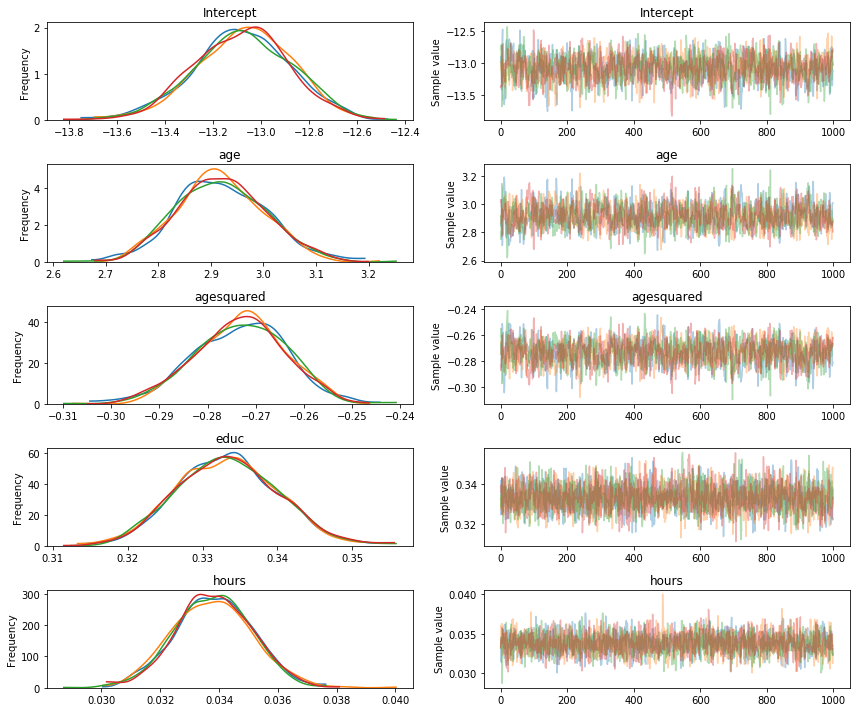

In [17]:
pm.traceplot(trace);

## Results

One of the major benefits that makes Bayesian data analysis worth the extra computational effort in many circumstances is that we can be explicit about our **uncertainty**. 

MLE returns a point estimate, but how ***certain*** can we be that we found the ***right*** number? Today in class you told me that Uber now gives you an estimate of uncertainty in driver arrival time. ***That*** *is* Bayesian inference! 

Let's use seaborn to look at the distribution of some of these factors.

<Figure size 648x504 with 0 Axes>

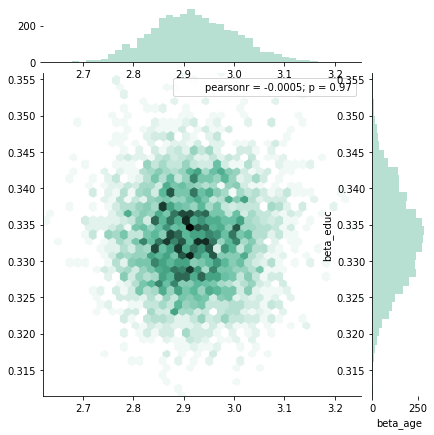

In [18]:
plt.figure(figsize=(9,7))
seaborn.jointplot(trace['age'], trace['educ'], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ");

So how do age and education affect the probability of making more than $50K? 

To answer this question, we can show how the probability of making more than $50K changes with age for a few different education levels.

Let's assume that the number of hours worked per week is fixed at 50. 

PyMC3 gives us a convenient way to plot the posterior predictive distribution. We need to give the function a linear model and a set of points to evaluate. We will pass in three different linear models: one with educ == 12 (finished high school), one with educ == 16 (finished undergrad) and one with educ == 19 (three years of grad school).

In [19]:
def lm_full(trace, age, educ, hours):
    shape = np.broadcast(age, educ, hours).shape
    x_norm = np.asarray([np.broadcast_to(x, shape)
                         for x in [age/10., educ, hours]])
    return 1 / (1 + np.exp(-(trace['Intercept'] +
                             trace['age']*x_norm[0] +
                             trace['agesquared']*(x_norm[0]**2) +
                             trace['educ']*x_norm[1] +
                             trace['hours']*x_norm[2])))

# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: lm_full(samples, x, 12., 50.)

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: lm_full(samples, x, 16., 50.)

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: lm_full(samples, x, 19., 50.)

Each curve (below) shows how the probability of earning more than $50K$ changes with age. The red curve represents 19 years of education, the green curve represents 16 years of education and the blue curve represents 12 years of education. 

For all three education levels, the probability of making more than $50K increases with age until approximately age 60, when the probability begins to drop off. Notice that each curve is a little blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. Because the curves are somewhat translucent, we can interpret dark, narrow portions of a curve as places where we have low uncertainty and light, spread out portions of the curve as places where we have somewhat higher uncertainty about our coefficient values.

That is the power of having a **model**. We can do data analysis with it!

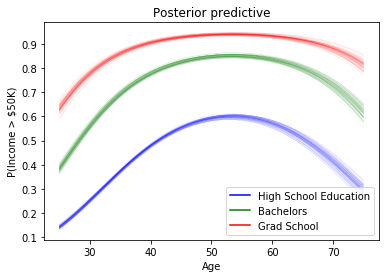

In [20]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    25, 75, 1000), lm=lm3, samples=100, color="red", alpha=.15)

import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='High School Education')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Bachelors')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Grad School')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

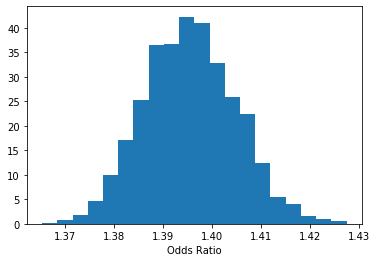

In [21]:
b = trace['educ']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()

Finally, we can find a **credible interval** (**credible intervals** are ***Bayesian*** and **confidence intervals** are ***frequentist***). 

This may be the best part about Bayesian statistics: we get to interpret credibility intervals the way we’ve always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval. Confidence intervals are voodoo math..

In [22]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P(%.3f < O.R. < %.3f) = 0.95" % (np.exp(lb),np.exp(ub)))

P(1.378 < O.R. < 1.414) = 0.95


## Model selection

One question that was immediately asked was ***what effect does age have on the model***, and why should it be **quadratic** with respect to age, or should it be **cubic**?? 

Let's run the model with a few changes to see what effect higher order terms have on this model in terms of the Watanabe–Akaike information criterion [WAIC](https://en.wikipedia.org/wiki/Watanabe%E2%80%93Akaike_information_criterion).

In [23]:
models_lin, traces_lin = run_models(data, 3)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, hours, educ, Intercept]
Sampling 4 chains: 100%|██████████| 8000/8000 [10:29<00:00,  3.67draws/s]  



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [np.power(age, 2), age, hours, educ, Intercept]
Sampling 4 chains: 100%|██████████| 8000/8000 [30:59<00:00,  1.08draws/s]  
The acceptance probability does not match the target. It is 0.8986843473650196, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [np.power(age, 3), np.power(age, 2), age, hours, educ, Intercept]
Sampling 4 chains: 100%|██████████| 8000/8000 [1:53:52<00:00,  3.59s/draws]  
The number of effective samples is smaller than 25% for some parameters.


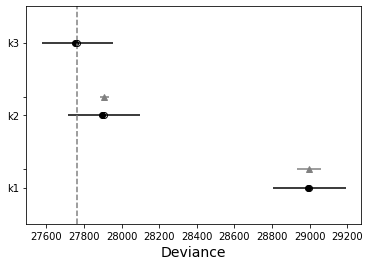

In [26]:
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})

dfwaic = pm.compare(model_trace_dict, ic='WAIC')
pm.compareplot(dfwaic);

WAIC confirms our decision to use a quadratic model, which is much better than the linear one. A cubic is slightly better, but not worth the computational complexity.